In [4]:
from google.colab import files      # For uploading/downloading files in Google Colab
print("Please upload your csv file")
uploaded = files.upload()  # Opens a file upload dialog box in Google Colab

Please upload your csv file


Saving AirPassengers.csv to AirPassengers.csv


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [5]:


# ============================================================
# STEP 1: LOAD THE DATA
# ============================================================

# Read the CSV file
# Make sure "AirPassengers.csv" is in the same folder as your notebook.
data = pd.read_csv("AirPassengers.csv")

# Typical AirPassengers file has columns: "Month" and "Passengers"
# Convert "Month" to a proper datetime object
data["month"] = pd.to_datetime(data["month"])

# Set "Month" as the index of the DataFrame (very common for time series)
data = data.set_index("month")

# Just keep the passengers column as a time series
ts = data["passengers"]

# For monthly data, we want a regular monthly frequency
# "MS" = Month Start, "M" = Month End.
# We'll use Month Start here.
ts = ts.asfreq("MS")

print("First few rows of the time series:")
print(ts.head())

First few rows of the time series:
month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Freq: MS, Name: passengers, dtype: int64


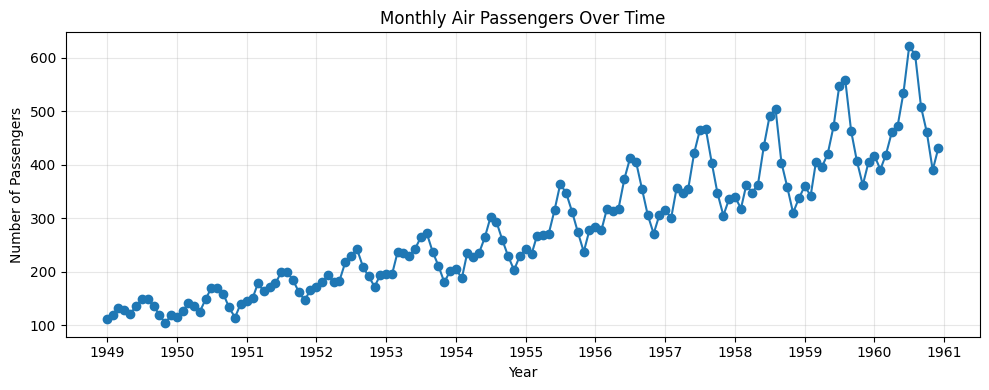

In [6]:

# ============================================================
# STEP 2: BASIC PLOT OF THE TIME SERIES
# ============================================================

plt.figure(figsize=(10, 4))
plt.plot(ts.index, ts, marker="o")
plt.title("Monthly Air Passengers Over Time")
plt.xlabel("Year")
plt.ylabel("Number of Passengers")
plt.grid(True, alpha=0.3)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())   # show ticks at each year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.tight_layout()
plt.show()



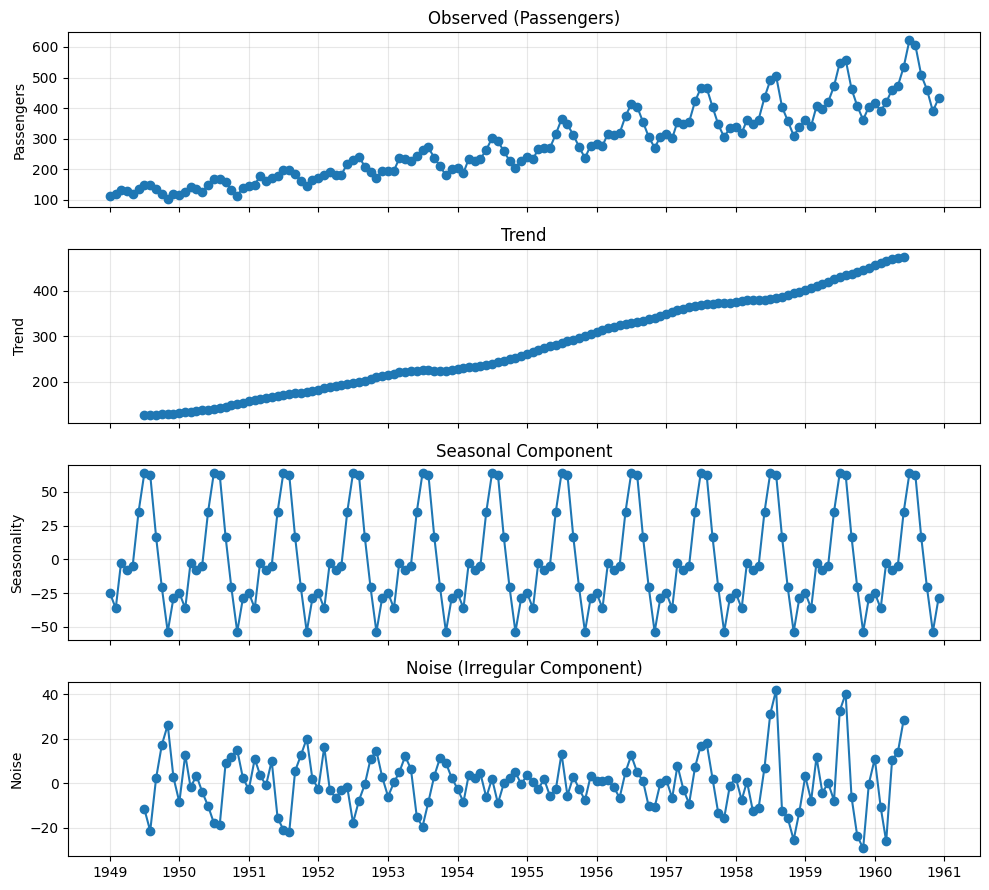

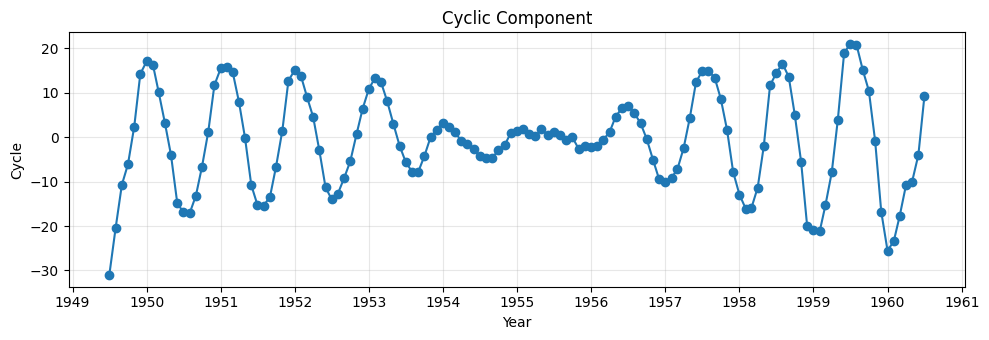

In [8]:

# ============================================================
# STEP 3: DECOMPOSE THE TIME SERIES
# Into: Trend, Seasonality, Residuals, plus Cyclicality
# ============================================================

# We know this is monthly data, so we assume yearly seasonality → period = 12 months
decomp = seasonal_decompose(ts, model="additive", period=12)

trend = decomp.trend        # long-term direction
seasonal = decomp.seasonal  # pattern that repeats each year
resid = decomp.resid        # what's left after removing trend + seasonality

# ---- CYCLICALITY ----
# Cycles = slower ups and downs not tied to a fixed length like "1 year".
# We approximate cycles by smoothing the residuals with a moving average.
cycle = resid.rolling(window=6, center=True, min_periods=3).mean()

# Whatever remains after removing this cycle from residuals we call "noise"
noise = resid - cycle

# ---- Plot the decomposition: Observed, Trend, Seasonality, Noise ----
fig, axes = plt.subplots(4, 1, figsize=(10, 9), sharex=True)

axes[0].plot(ts.index, ts, marker="o")
axes[0].set_title("Observed (Passengers)")
axes[0].set_ylabel("Passengers")
axes[0].grid(True, alpha=0.3)

axes[1].plot(trend.index, trend, marker="o")
axes[1].set_title("Trend")
axes[1].set_ylabel("Trend")
axes[1].grid(True, alpha=0.3)

axes[2].plot(seasonal.index, seasonal, marker="o")
axes[2].set_title("Seasonal Component")
axes[2].set_ylabel("Seasonality")
axes[2].grid(True, alpha=0.3)

axes[3].plot(noise.index, noise, marker="o")
axes[3].set_title("Noise (Irregular Component)")
axes[3].set_ylabel("Noise")
axes[3].grid(True, alpha=0.3)

axes[3].xaxis.set_major_locator(mdates.YearLocator())
axes[3].xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

plt.tight_layout()
plt.show()

# ---- Plot Cyclicality separately ----
plt.figure(figsize=(10, 3.5))
plt.plot(cycle.index, cycle, marker="o")
plt.title("Cyclic Component")
plt.xlabel("Year")
plt.ylabel("Cycle")
plt.grid(True, alpha=0.3)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.tight_layout()
plt.show()


In [9]:


# ============================================================
# STEP 4: ADF (AUGMENTED DICKEY-FULLER) TEST FOR STATIONARITY
# ============================================================

def run_adf_test(series, title):
    """
    Runs the ADF test on a time series and prints an easy-to-understand summary.
    """

    series = series.dropna()

    result = adfuller(series)

    p_value = result[1]

    print(f"p-value       : {p_value}")

    if p_value <= 0.05:
        print("Conclusion: p-value <= 0.05 → reject H0 → series is LIKELY STATIONARY.")
    else:
        print("Conclusion: p-value > 0.05 → fail to reject H0 → series is LIKELY NON-STATIONARY.")


# ADF test on original series
run_adf_test(ts, "ADF Test on ORIGINAL Passenger Series")

p-value       : 0.991880243437641
Conclusion: p-value > 0.05 → fail to reject H0 → series is LIKELY NON-STATIONARY.


In [10]:
# ============================================================
# STEP 5: TRAIN / TEST SPLIT
# ============================================================
# We will use the last 12 months as TEST data
# Everything before that is TRAIN data.

test_size = 12  # months
train = ts.iloc[:-test_size]
test = ts.iloc[-test_size:]

In [11]:

# ============================================================
# STEP 6: FIT A SIMPLE ARIMA MODEL
# ============================================================
# ARIMA(p, d, q)
# For simplicity in teaching, we choose ARIMA(1, 1, 1).
# In practice, we should tune p, d, q using AIC/BIC or auto_arima.

model_order = (1, 1, 1)

print(f"\nFitting ARIMA{model_order} model on TRAIN data...")

arima_model = ARIMA(train, order=model_order)
arima_result = arima_model.fit()

print("\nModel fitted. Short summary:")
print(arima_result.summary())



Fitting ARIMA(1, 1, 1) model on TRAIN data...

Model fitted. Short summary:
                               SARIMAX Results                                
Dep. Variable:             passengers   No. Observations:                  132
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -625.518
Date:                Wed, 19 Nov 2025   AIC                           1257.035
Time:                        01:05:35   BIC                           1265.661
Sample:                    01-01-1949   HQIC                          1260.540
                         - 12-01-1959                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5436      0.100     -5.443      0.000      -0.739      -0.348
ma.L1          0.9272      0.051     18.336      0.000

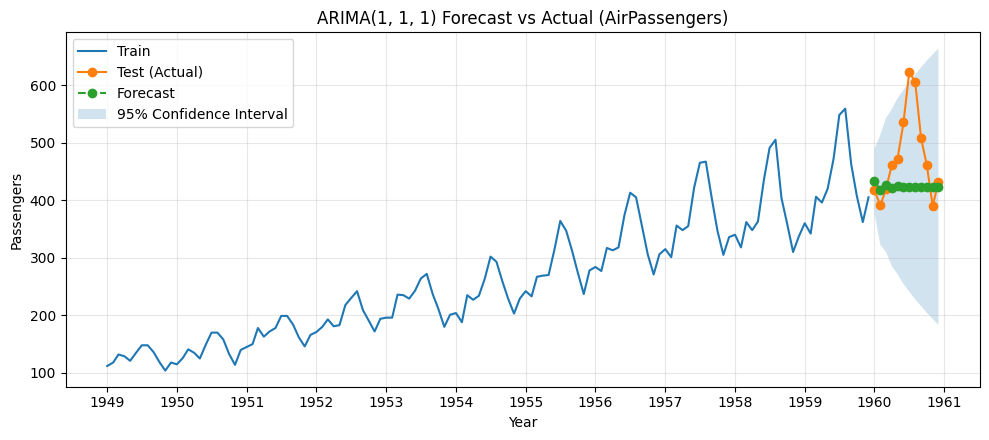


Forecast Accuracy on TEST set:
RMSE: 91.23
MAE : 66.24

(Compare these errors to typical passenger counts to judge if it's 'big' or 'small').


In [13]:
# ============================================================
# STEP 7: FORECAST ON TEST PERIOD AND PLOT RESULTS
# ============================================================

# Number of forecast steps = length of test set (12 months)
n_test = len(test)

forecast_obj = arima_result.get_forecast(steps=n_test)
forecast_mean = forecast_obj.predicted_mean
forecast_ci = forecast_obj.conf_int()

# Align forecast index with test index
forecast_mean.index = test.index
forecast_ci.index = test.index

# Plot Actual vs Forecast
plt.figure(figsize=(10, 4.5))
plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, marker="o", label="Test (Actual)")
plt.plot(forecast_mean.index, forecast_mean, marker="o", linestyle="--",
         label="Forecast")

plt.fill_between(
    forecast_ci.index,
    forecast_ci.iloc[:, 0],
    forecast_ci.iloc[:, 1],
    alpha=0.2,
    label="95% Confidence Interval"
)

plt.title(f"ARIMA{model_order} Forecast vs Actual (AirPassengers)")
plt.xlabel("Year")
plt.ylabel("Passengers")
plt.legend()
plt.grid(True, alpha=0.3)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.tight_layout()
plt.show()

# Forecast accuracy
rmse = sqrt(mean_squared_error(test, forecast_mean))
mae = mean_absolute_error(test, forecast_mean)

print("\nForecast Accuracy on TEST set:")
print(f"RMSE: {rmse:,.2f}")
print(f"MAE : {mae:,.2f}")




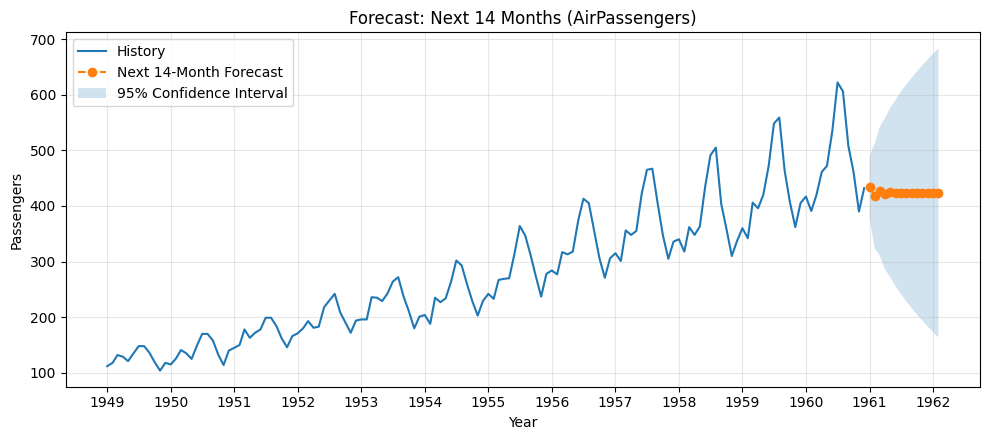


Next 14-Month Forecast (AirPassengers):
1961-01-01    433.451927
1961-02-01    417.984221
1961-03-01    426.393139
1961-04-01    421.821685
1961-05-01    424.306927
1961-06-01    422.955841
1961-07-01    423.690350
1961-08-01    423.291039
1961-09-01    423.508122
1961-10-01    423.390106
1961-11-01    423.454265
1961-12-01    423.419385
1962-01-01    423.438347
1962-02-01    423.428039
Freq: MS, Name: predicted_mean, dtype: float64


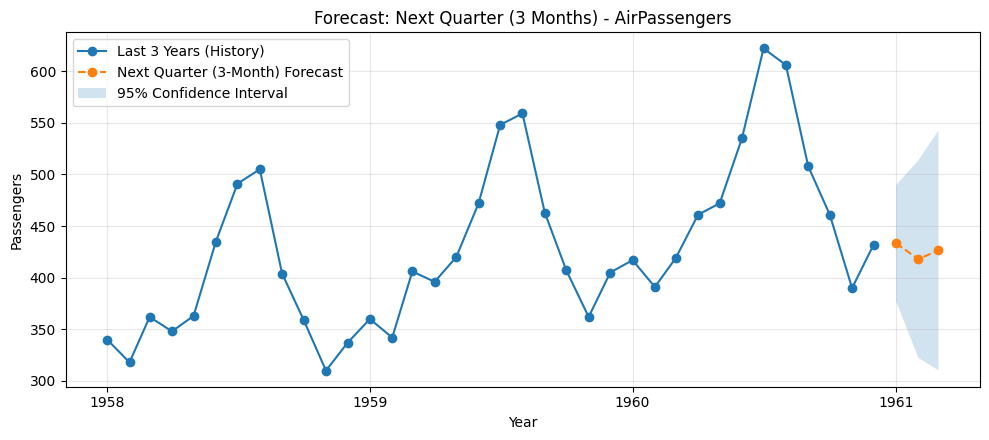


Next Quarter (3-Month) Forecast (AirPassengers):
1961-01-01    433.451927
1961-02-01    417.984221
1961-03-01    426.393139
Freq: MS, Name: predicted_mean, dtype: float64


In [14]:

# ============================================================
# STEP 8: EXTRA FORECASTS
# - Next 14 MONTHS (since data is monthly)
# - Next QUARTER (3 months)
# ============================================================

# ---------- A. Next 14 MONTHS ----------
n_future_months = 14

future_forecast_obj = arima_result.get_forecast(steps=n_future_months)
future_mean = future_forecast_obj.predicted_mean
future_ci = future_forecast_obj.conf_int()

# Create future monthly index starting from the month after the last observation
future_index = pd.date_range(
    start=ts.index[-1] + pd.offsets.MonthBegin(),
    periods=n_future_months,
    freq="MS"   # Month Start
)

future_mean.index = future_index
future_ci.index = future_index

plt.figure(figsize=(10, 4.5))
plt.plot(ts.index, ts, label="History")
plt.plot(future_mean.index, future_mean, marker="o", linestyle="--",
         label="Next 14-Month Forecast")

plt.fill_between(
    future_ci.index,
    future_ci.iloc[:, 0],
    future_ci.iloc[:, 1],
    alpha=0.2,
    label="95% Confidence Interval"
)

plt.title("Forecast: Next 14 Months (AirPassengers)")
plt.xlabel("Year")
plt.ylabel("Passengers")
plt.legend()
plt.grid(True, alpha=0.3)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.tight_layout()
plt.show()

print("\nNext 14-Month Forecast (AirPassengers):")
print(future_mean)


# ---------- B. Next QUARTER (NEXT 3 MONTHS) ----------
n_quarter_months = 3

quarter_forecast_obj = arima_result.get_forecast(steps=n_quarter_months)
quarter_mean = quarter_forecast_obj.predicted_mean
quarter_ci = quarter_forecast_obj.conf_int()

quarter_index = pd.date_range(
    start=ts.index[-1] + pd.offsets.MonthBegin(),
    periods=n_quarter_months,
    freq="MS"
)

quarter_mean.index = quarter_index
quarter_ci.index = quarter_index

plt.figure(figsize=(10, 4.5))
plt.plot(ts.index[-36:], ts[-36:], marker="o", label="Last 3 Years (History)")
plt.plot(quarter_mean.index, quarter_mean, marker="o", linestyle="--",
         label="Next Quarter (3-Month) Forecast")

plt.fill_between(
    quarter_ci.index,
    quarter_ci.iloc[:, 0],
    quarter_ci.iloc[:, 1],
    alpha=0.2,
    label="95% Confidence Interval"
)

plt.title("Forecast: Next Quarter (3 Months) - AirPassengers")
plt.xlabel("Year")
plt.ylabel("Passengers")
plt.legend()
plt.grid(True, alpha=0.3)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.tight_layout()
plt.show()

print("\nNext Quarter (3-Month) Forecast (AirPassengers):")
print(quarter_mean)
